## Simulating
### General Imports

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Circle, Wedge, Polygon,Patch
from matplotlib.collections import PatchCollection, LineCollection,PathCollection
from matplotlib.colors import rgb_to_hsv
from matplotlib.lines import Line2D
from objects import UniformFeatureDistribution,CategoricalFeatureDistribution, MixtureDistribution, Individual, Parameters,Populace, Hub, Region, Area
from shapely.geometry import Point, Polygon,box
# https://matplotlib.org/tutorials/colors/colormaps.ht
number_desired_colors = 8
cmap = plt.cm.get_cmap('nipy_spectral',number_desired_colors)
colors = [cmap(i) for i in range(number_desired_colors)]

Each individual has parameters $\theta =(\theta_u,\theta_p)$. There are two subpopulations:
* For subpopulation $1$, $\theta_u = 1, \theta_p=1$
* For subpopulation $2$, $\theta_u =2, \theta_p = 2$

In [9]:
## Type 1 Subpopulation
theta_u_type1_value = 1
theta_p_type1_value = 1
featureDistribution1 = CategoricalFeatureDistribution(theta_u_type1_value,theta_p_type1_value)

## Type 2 Subpopulation
theta_u_type2_value = 2
theta_p_type2_value = 2
featureDistribution2 = CategoricalFeatureDistribution(theta_u_type2_value,theta_p_type2_value)

nMixed = 100
mixtureDistribution = MixtureDistribution([featureDistribution1,featureDistribution2],[0.75,0.25])
pop = Populace(mixtureDistribution,nMixed)

* The `Region` instance `r` is the square of side length $100$ at the origin in quadrant $1$. Each `Hub` is a circle of radius `sizeHub`, whose center is distributed uniformly randomly in `r` (such that it is fully contained). Hubs can overlap.

* Each subpopulation (a `Populace`) will be divided among the overall `Region` into clusters called `hub`s. There are `nHubsEachType` hubs dedicated to each subpopulation; each `hub` has `nPerHub` individuals.

There are `nFacilities` facilities, also distributed uniformly throughout `r`.

In [10]:
sizeRegion = 100
nPerHub = 5
sizeHub = 5
r = Region(sizeRegion,sizeHub,nPerHub)
r.populate(pop)
nFacilities = 20
r.generateFacilitiesBasedOnSumOfParameters(nFacilities)

## Plotting:

### Plotting objects

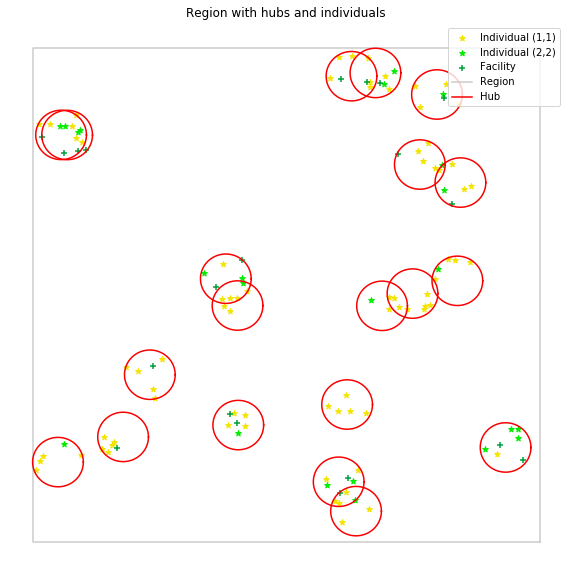

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
plt.title(f"Region with hubs and individuals")

## Plot Region
labelRegion="Region"
plt.plot(*r.getExteriorCoords(),color=colors.pop(),label=labelRegion)

## Plot Hubs
labelHub="Hub"
plt.plot(*r.getHubCoordinates(), color=colors.pop(),label=labelHub)

## Plot Individuals
labelIndividuals = "Individual"
def plotIndividuals():
	# plt.scatter(*pop.getIndividualCoordinates(),marker="*",c="blue",label="Individual")
	weights = pop.getIndividualParameterSums()
	color_weight_map = {weight : colors.pop() for weight in set(weights)}
	individual_colors = [color_weight_map[weight] for weight in weights]
	individual_labels = [f"{labelIndividuals} ({individual.parameters.unprotected},{individual.parameters.protected})" for individual in r.individuals]
	for i,individual in enumerate(r.individuals):
		plt.scatter(*individual.location.xy,marker = "*",c=[individual_colors[i]],label=individual_labels[i])

plotIndividuals()

## Plot Facilities
labelFacility = "Facility"
plt.scatter(*r.getFacilityLocations(),marker="+",c=[colors.pop()],label=labelFacility)

## Create Legend
legend_dict = {artist.properties().get('label') : artist for artist in ax.collections.copy() + ax.lines.copy()}
plt.legend(legend_dict.values(),legend_dict.keys(),loc="upper right")

plt.draw()
plt.show()

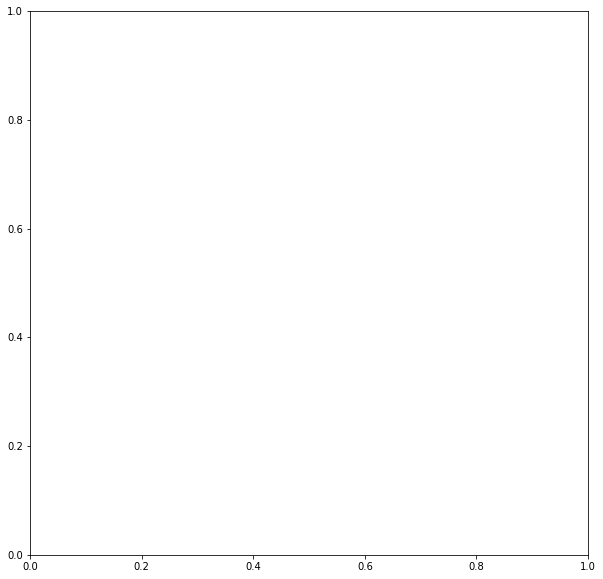

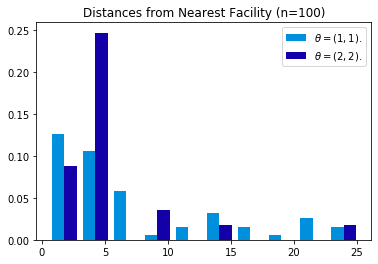

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title(f"Distances from Nearest Facility (n={len(r.individuals)})")


def get_distances_to_facilities(individuals):
	# for individual in r.individuals:
		# dist_to_nearest = min([individual.location.distance(hub.geom) for hub in r.hubs])
	return [min([individual.location.distance(facilityLocation) for facilityLocation in r.facilityLocations]) for individual in individuals]



individualsType1 = r.queryIndividualsByParameter(Parameters((1,1)))
individualsType2 = r.queryIndividualsByParameter(Parameters((2,2)))
subPops = [individualsType1,individualsType2]
distances_total = get_distances_to_facilities(r.individuals)
subPopDistances = [get_distances_to_facilities(subPop) for subPop in subPops]

num_bins = 10
n,bins,patches = plt.hist(subPopDistances,num_bins,color = [colors.pop() for subpop in subPopDistances],density=True)
for patch,pop in zip(patches,subPops):
	patch.set_label( f"$\\theta = ({pop[0].parameters.unprotected},{pop[0].parameters.protected}).$")

# legend_dict = {artist.properties().get('label') : artist for artist in ax.collections.copy() + ax.lines.copy()}
plt.legend(handles=patches,loc="upper right")